<a href="https://colab.research.google.com/github/saurabh2086/statistical_rethinking/blob/main/statistical_rethinking_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install -U git+https://github.com/arviz-devs/arviz.git
# !pip install -U git+https://github.com/pymc-devs/pymc3.git
!pip install --upgrade pymc3 
!pip install arviz

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import pymc3 as pm
import scipy as sc 

import arviz as az

import theano.tensor as tt

In [ ]:
def sim_pancake():
  pancake = np.random.choice(3,1)
  sides = np.array([[1, 1], [1,0], [0, 0]])[pancake,:].ravel()
  return np.random.choice(sides, 1)[0], pancake[0]



# Code 15.1

In [ ]:
# sim 10,000 pancakes
num_simulation = 10000
pancakes = np.zeros(num_simulation)
sides = np.zeros(num_simulation)

for i in range(num_simulation):
  side, pancake = sim_pancake()
  pancakes[i] = pancake
  sides[i] = side

# find if the face is burned 
index = sides == 1 
# filter out those cases 
pancakes_ = pancakes[index]
prob = np.sum(pancakes_ == 0)/len(pancakes_)
print(prob)

0.6655942087271265


# Code 15.2

In [ ]:
# 15.2
waffle = "https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking_2/Data/WaffleDivorce.csv"
d = pd.read_csv(waffle, delimiter=";")
d.head()


,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


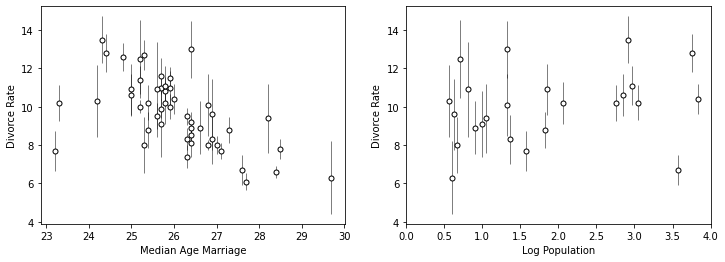

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].errorbar(d.MedianAgeMarriage, 
             d.Divorce, 
             d['Divorce SE'],
             fmt='.', 
             color='k', 
             linewidth=0.5,
             markerfacecolor='white',
             markersize=10
             )
ax[0].set_xlabel("Median Age Marriage")
ax[0].set_ylabel("Divorce Rate")

ax[1].errorbar(d.Population, 
             d.Divorce, 
             d['Divorce SE'],
             fmt='.', 
             color='k', 
             linewidth=0.5,
             markerfacecolor='white',
             markersize=10
             )
ax[1].set_xlim(0, 4)
ax[1].set_xlabel("Log Population")
ax[1].set_ylabel("Divorce Rate")

plt.show()

$$D_{obs, i} \sim Normal(D_{TRUE, i}, D_{SE,i}) $$
$$D_{TRUE, i} \sim Normal(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_A A_i + \beta_M M_i$$
$$\alpha \sim Normal(0, 0.2)$$
$$\beta_A \sim Normal(0, 0.5)$$
$$\beta_M \sim Normal(0, 0.5)$$
$$ \sigma \sim Exponential(1)$$

In [ ]:
def standardize(x):
  return (x - np.mean(x))/np.std(x)

# Code 15.3

In [ ]:
D_obs = standardize(d.Divorce)
D_sd = d['Divorce SE']/np.std(d['Divorce'])
M_ = standardize(d['Marriage'])
A_ = standardize(d['MedianAgeMarriage'])
N = len(d)

with pm.Model() as m15_1:
  A = pm.Data("A", A_)
  alpha = pm.Normal("a", 0, 0.2)
  bA = pm.Normal("bA", 0, 0.5)
  bM = pm.Normal("bM", 0, 0.5)
  sigma = pm.Exponential("sigma", 1)
  mu = alpha + bA * A + bM * M_ 
  D_true = pm.Normal("D_true", mu, sigma, shape=N)
  obs = pm.Normal("D_obs", mu=D_true, sigma=D_sd, observed=D_obs)

  trace_15_1 = pm.sample()

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [D_true, sigma, bM, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


In [ ]:
pm.summary(trace_15_1,round_to=2)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.06,0.10,-0.25,0.12,0.00,0.00,1346.25,1293.99,1349.83,1442.48,1.0
bA,-0.61,0.15,-0.89,-0.32,0.00,0.00,994.86,994.86,999.24,1222.28,1.0
bM,0.05,0.16,-0.26,0.35,0.01,0.00,1037.91,1037.91,1036.82,1280.73,1.0
D_true[0],1.17,0.36,0.44,1.82,0.01,0.01,1711.72,1677.47,1704.74,1272.25,1.0
D_true[1],0.67,0.57,-0.37,1.78,0.01,0.01,1873.44,1275.33,1882.48,1273.22,1.0
D_true[2],0.42,0.34,-0.25,1.02,0.01,0.01,3017.95,1632.28,3117.76,1335.03,1.0
D_true[3],1.42,0.47,0.59,2.28,0.01,0.01,1597.83,1595.70,1584.50,1416.80,1.0
D_true[4],-0.91,0.13,-1.19,-0.67,0.00,0.00,2885.39,2885.39,2918.26,1223.20,1.0
D_true[5],0.65,0.39,-0.04,1.41,0.01,0.01,2055.66,1739.36,2049.83,1326.55,1.0
D_true[6],-1.38,0.37,-2.05,-0.65,0.01,0.01,2365.28,2266.84,2380.31,1409.09,1.0


In [ ]:
with m15_1:
  x_range = np.linspace(M_.min()-0.15, M_.max() + 0.15, 50)
  pm.set_data({"A":x_range})
  trace_posterior_15_1 = pm.fast_sample_posterior_predictive(trace_15_1, var_names=['D_true'])


#Code15.4

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


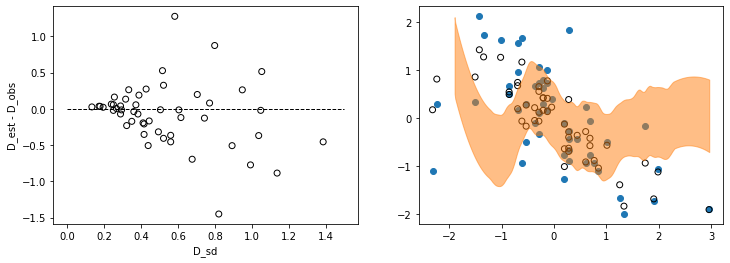

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(12,4))
D_diff = trace_15_1['D_true'].mean(axis=0) - D_obs
ax[0].scatter(D_sd, D_diff,marker='o', edgecolors='k', facecolors='none')
ax[0].hlines(0, 0, 1.5, linestyles='dashed', lw=1)
ax[0].set_xlabel("D_sd")
ax[0].set_ylabel("D_est - D_obs")

ax[1].scatter(A_, D_obs)
ax[1].scatter(A_, trace_15_1['D_true'].mean(0), facecolor='none', edgecolor='k')
pm.plot_hdi(x_range, trace_posterior_15_1['D_true'], ax=ax[1])

# Code 15.5

In [ ]:
D_obs = standardize(d['Divorce'])
D_sd = d['Divorce SE']/np.std(d['Divorce'])
M_obs = standardize(d['Marriage'])
M_sd = d['Marriage SE'] / np.std(d['Marriage'])
A = standardize(d['MedianAgeMarriage'])
N = len(d)

with pm.Model() as m15_2:
  a = pm.Normal("a", 0, 0.2)
  bA = pm.Normal("bA", 0, 0.5)
  bM = pm.Normal("bM", 0, 0.5)
  sigma = pm.Exponential("sigma", 1)
  M_true = pm.Normal("M_true",0, 1, shape=N)
  Mobs = pm.Normal("M_obs", M_true, M_sd, observed=M_obs)
  mu = a + bA * A + bM * M_true
  D_true = pm.Normal("D_true", mu, sigma, shape=N)
  obs = pm.Normal("D_obs", D_true, D_sd, observed=D_obs)

  trace_15_2 = pm.sample(2000, tune=2000, target_accept =0.95)


/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [D_true, M_true, sigma, bM, bA, a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.


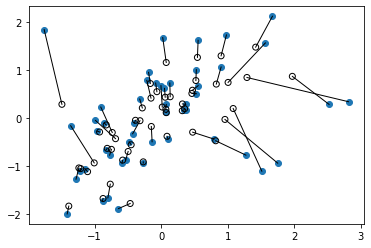

In [ ]:
D_true = trace_15_2['D_true'].mean(0)
M_true = trace_15_2['M_true'].mean(0)
_, ax = plt.subplots()
ax.scatter(M_obs, D_obs)
ax.scatter(M_true, D_true, edgecolors='k', facecolors='none')
for m_obs, d_obs, m_true, d_true in zip(M_obs, D_obs,M_true, D_true):
  plt.plot([m_obs, m_true],[d_obs, d_true], color='k', lw=1)


# Code 15.8

In [ ]:
N = 100
S = np.random.randn(N)
H = np.random.binomial(10, sc.special.expit(S),N)


# Code 15.9

In [ ]:
# Dog eat homework of random student
D = np.random.binomial(1, 0.5, 100)
Hm = H.astype(float)
Hm[D == 1] = np.nan


# Code 15.10

In [ ]:
# Dog eat homework of studius student
D = np.where(S > 0, 1, 0)
Hm = np.where(D == 1, np.nan, H)
Hm

array([nan,  2., nan, nan,  1.,  2.,  3.,  3., nan,  5., nan,  1.,  2.,
       nan, nan,  4.,  4.,  4.,  3.,  4.,  3.,  3., nan,  3.,  5.,  7.,
        6.,  1., nan, nan,  3.,  3., nan, nan, nan,  2.,  1., nan, nan,
       nan,  6., nan, nan,  5., nan, nan,  3., nan, nan,  3., nan, nan,
        4.,  3.,  4.,  1., nan,  1.,  2., nan, nan, nan,  4.,  4., nan,
        2.,  6., nan,  1., nan, nan, nan, nan,  7., nan,  3., nan, nan,
        2., nan, nan, nan,  3., nan,  4.,  4.,  1.,  5., nan,  4., nan,
       nan,  4.,  5.,  6.,  3.,  4., nan, nan, nan])

# Code 15.11

In [ ]:
np.random.seed(501)
N = 1000
X = np.random.randn(N)
S_ = np.random.randn(N)
H_ = np.random.binomial(10, sc.special.expit(2 + S_ - 2 * X), N)
D = np.where(X > 1, 1, 0)
Hm = H_.astype(float)
Hm[D == 1] = np.nan


# Code 15.12

In [ ]:
with pm.Model() as m15_3:
  H = pm.Data("H", H_)
  S = pm.Data("S", S_)
  a = pm.Normal("a", 0, 1)
  bS = pm.Normal("bS", 0, 0.5)
  p = pm.math.invlogit(a + bS * S)
  obs = pm.Binomial("obs", 10,p, observed=H)

  trace_15_3 = pm.sample()

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [bS, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [ ]:
pm.summary(trace_15_3)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.268,0.027,1.214,1.315,0.001,0.000,1514.0,1514.0,1513.0,1467.0,1.0
bS,0.708,0.028,0.658,0.760,0.001,0.001,1530.0,1530.0,1533.0,1386.0,1.0


# Code 15.13

In [ ]:
with pm.Model() as m15_4:
  H = pm.Data("H", H_[D == 0])
  S = pm.Data("S", S_[D == 0])
  a = pm.Normal("a", 0, 1)
  bS = pm.Normal("bS", 0, 0.5)
  p = pm.math.invlogit(a + bS * S)
  obs = pm.Binomial("obs", 10,p, observed=H)

  trace_15_4 = pm.sample()

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [bS, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


In [ ]:
pm.summary(trace_15_4)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.878,0.036,1.805,1.942,0.001,0.001,1200.0,1200.0,1201.0,1251.0,1.0
bS,0.860,0.035,0.794,0.928,0.001,0.001,1142.0,1142.0,1150.0,887.0,1.0


# Code 15.14

In [ ]:
N = 100
S = np.random.normal(size=100)
H = np.random.binomial(10, sc.special.expit(S),100)
D = np.where(H < 5, 1, 0)
Hm = H.astype(float)
Hm[D == 1] = np.nan

In [ ]:
def standardize(x):
  return (x - x.mean())/x.std()

# Code 15.15

In [ ]:
milk = "https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking_2/Data/milk.csv"
d = pd.read_csv(milk,delimiter=";")
d['neocortex.prop'] = d['neocortex.perc'] / 100
d['logmass'] = np.log(d['mass'])
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,neocortex.prop,logmass
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,0.5516,0.667829
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,NaN,0.737164
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,NaN,0.920283
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,NaN,0.482426
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,NaN,0.783902


# Code 15.16

In [ ]:
K_ = standardize(d['kcal.per.g'])
B_ = standardize(d['neocortex.prop'])
M_ = standardize(d['logmass'])

with pm.Model() as m15_5:
  sigma = pm.Exponential("sigma",1)
  sigma_B = pm.Exponential("sigma_B",1)
  a = pm.Normal("a", 0, 0.5)
  nu = pm.Normal("nu", 0, 0.5)
  bB = pm.Normal("bB", 0, 0.5)
  bM = pm.Normal("bM", 0, 0.5)
  B = pm.Normal("B", nu, sigma_B, observed=B_)
  mu = a + bB * B + bM * M_
  K = pm.Normal("K", mu, sigma, observed=K_)

  trace_15_5 = pm.sample(target_accept=0.9)


/usr/local/lib/python3.7/dist-packages/pymc3/model.py:1755: ImputationWarning: Data in B contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  app.launch_new_instance()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [B_missing, bM, bB, nu, a, sigma_B, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


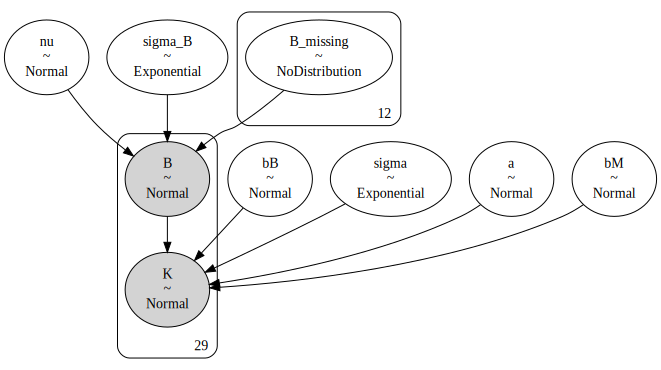

In [ ]:
pm.model_to_graphviz(m15_5)

# Code 15.18

In [ ]:
pm.summary(trace_15_5)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.030,0.165,-0.285,0.328,0.004,0.004,1863.0,1357.0,1.0
nu,-0.053,0.204,-0.442,0.328,0.006,0.004,1309.0,1610.0,1.0
bB,0.500,0.227,0.056,0.887,0.008,0.006,793.0,1517.0,1.0
bM,-0.545,0.198,-0.915,-0.173,0.006,0.004,1190.0,1443.0,1.0
B_missing[0],-0.572,0.897,-2.136,1.258,0.021,0.017,1813.0,1338.0,1.0
B_missing[1],-0.702,0.888,-2.334,0.988,0.023,0.019,1556.0,1306.0,1.0
B_missing[2],-0.747,0.931,-2.454,1.052,0.022,0.019,1829.0,1550.0,1.0
B_missing[3],-0.280,0.892,-1.973,1.390,0.021,0.022,1801.0,1313.0,1.0
B_missing[4],0.469,0.886,-1.229,2.130,0.019,0.018,2183.0,1428.0,1.0
B_missing[5],-0.186,0.903,-1.890,1.465,0.020,0.021,2071.0,1557.0,1.0


# Code 15.19

In [ ]:
index = d['neocortex.prop'].notna().values
print(index.sum())

17


In [ ]:
K_ = standardize(d['kcal.per.g'].values[index])
B_ = standardize(d['neocortex.prop'].values[index])
M_ = standardize(d['logmass'].values[index])
print(K_.shape, B_.shape, M_.shape)

(17,) (17,) (17,)


In [ ]:
K_ = standardize(d['kcal.per.g'].values[index])
B_ = standardize(d['neocortex.prop'].values[index])
M_ = standardize(d['logmass'].values[index])

with pm.Model() as m15_6:
  sigma = pm.Exponential("sigma",1)
  sigma_B = pm.Exponential("sigma_B",1)
  a = pm.Normal("a", 0, 0.5)
  nu = pm.Normal("nu", 0, 0.5)
  bB = pm.Normal("bB", 0, 0.5)
  bM = pm.Normal("bM", 0, 0.5)
  B = pm.Normal("B", nu, sigma_B, observed=B_)
  mu = a + bB * B + bM * M_
  K = pm.Normal("K", mu, sigma, observed=K_)

  trace_15_6 = pm.sample()


/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [bM, bB, nu, a, sigma_B, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


In [ ]:
pm.summary(trace_15_6)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.002,0.192,-0.343,0.381,0.005,0.005,1430.0,868.0,1452.0,1221.0,1.0
nu,0.004,0.231,-0.449,0.415,0.006,0.006,1712.0,796.0,1715.0,1148.0,1.0
bB,0.570,0.256,0.118,1.056,0.007,0.005,1334.0,1334.0,1349.0,1355.0,1.0
bM,-0.671,0.256,-1.122,-0.179,0.007,0.005,1242.0,1242.0,1268.0,1394.0,1.0
sigma,0.839,0.173,0.565,1.189,0.005,0.004,1152.0,1142.0,1138.0,949.0,1.0
sigma_B,1.071,0.194,0.744,1.434,0.005,0.004,1341.0,1234.0,1557.0,1106.0,1.0


# Code 15.20

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f718d3f3080>],
      dtype=object)

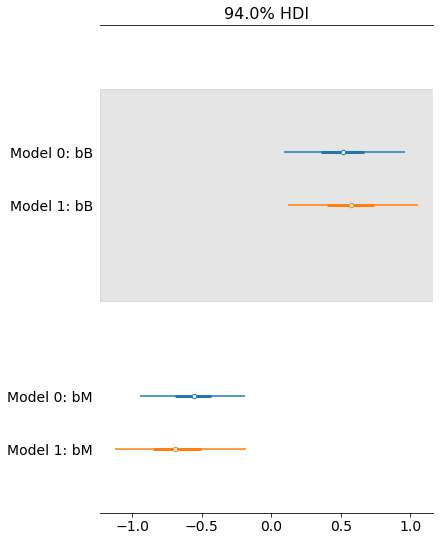

In [ ]:
pm.plot_forest([trace_15_5, trace_15_6], var_names=["bB", "bM"],combined=True)

In [ ]:
B_impute_mu = trace_15_5["B_missing"].mean(0)
B_impute_sd = trace_15_5["B_missing"].std(0)

In [ ]:
B_impute_mu.shape

(12,)

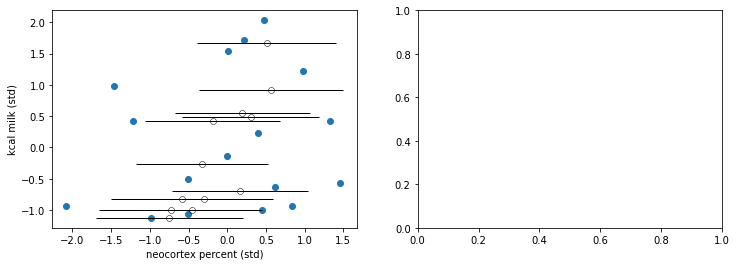

In [ ]:
K_ = standardize(d['kcal.per.g']).values
B_ = standardize(d['neocortex.prop']).values
M_ = standardize(d['logmass']).values

_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(B_[index], K_[index])
ax[0].errorbar(B_impute_mu, K_[~index],xerr=B_impute_sd, 
               fmt='o',
               color='k', 
               markerfacecolor='none',
               markeredgewidth = 0.5,
               elinewidth = 1)
ax[0].set_xlabel("neocortex percent (std)")
ax[0].set_ylabel("kcal milk (std)")

ax[0].scatter(B_[index], K_[index])
ax[0].errorbar(B_impute_mu, K_[~index],xerr=B_impute_sd, 
               fmt='o',
               color='k', 
               markerfacecolor='none',
               markeredgewidth = 0.5,
               elinewidth = 1)
ax[0].set_xlabel("neocortex percent (std)")
ax[0].set_ylabel("kcal milk (std)")

plt.show()

In [ ]:
d["neocortex.prop"] = d["neocortex.perc"] / 100
d["logmass"] = np.log(d["mass"])

K = standardize(d["kcal.per.g"])
B = standardize(d["neocortex.prop"])
M = standardize(d["logmass"])

print(f"Number of missing values in B = {np.sum(B.isna())}")

X_masked = np.ma.masked_invalid(np.stack([B, M]).T)
print(X_masked.shape)

Number of missing values in B = 12
(29, 2)


In [ ]:
d['neocortex.prop'].values

array([0.5516,    nan,    nan,    nan,    nan, 0.6454, 0.6454, 0.6764,
          nan, 0.6885, 0.5885, 0.6169, 0.6032,    nan,    nan, 0.6997,
          nan, 0.7041,    nan, 0.734 ,    nan, 0.6753,    nan, 0.7126,
       0.726 ,    nan, 0.7024, 0.763 , 0.7549])

In [ ]:
MB_masked = np.ma.masked_invalid(np.stack([M, B]).T)

with pm.Model() as m15_7:
    sigma = pm.Exponential("sigma", 1)
    muM = pm.Normal("muM", 0, 0.5)
    muB = pm.Normal("muB", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    bB = pm.Normal("bB", 0, 0.5)
    a = pm.Normal("a", 0, 0.5)

    chol, _, _ = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1), compute_corr=True
    )

    # M and B correlation
    MB = pm.MvNormal("MB", mu=tt.stack([muM, muB]), chol=chol, observed=MB_masked)

    mu = a + bB * MB[:, 1] + bM * M

    Ki = pm.Normal("Ki", mu, sigma, observed=K)

    idata_m15_7 = pm.sample(return_inferencedata=True)

idata_m15_7.posterior = idata_m15_7.posterior.rename_vars({"chol_cov_corr": "Rho_MB"})
# Strong correlation between M and B
az.summary(idata_m15_7, var_names=["bM", "bB", "Rho_MB"], round_to=2)

/usr/local/lib/python3.6/dist-packages/pymc3/model.py:1731: ImputationWarning: Data in MB contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [MB_missing, chol_cov, a, bB, bM, muB, muM, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,-0.63,0.23,-1.02,-0.19,0.01,0.00,1019.33,1019.33,1022.35,1357.97,1.0
bB,0.57,0.27,0.05,1.05,0.01,0.01,942.30,942.30,953.80,1252.63,1.0
"Rho_MB[0,0]",1.00,0.00,1.00,1.00,0.00,0.00,2000.00,2000.00,2000.00,2000.00,NaN
"Rho_MB[0,1]",0.60,0.14,0.35,0.84,0.00,0.00,1565.11,1442.33,1426.63,1355.22,1.0
"Rho_MB[1,0]",0.60,0.14,0.35,0.84,0.00,0.00,1565.11,1442.33,1426.63,1355.22,1.0
"Rho_MB[1,1]",1.00,0.00,1.00,1.00,0.00,0.00,2000.00,2000.00,1947.76,1719.53,1.0


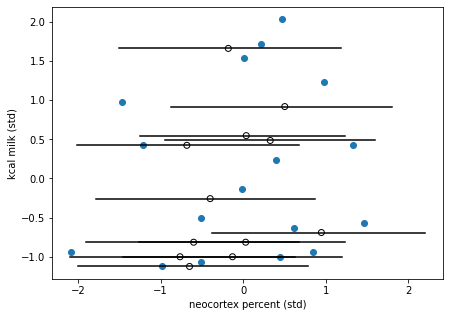

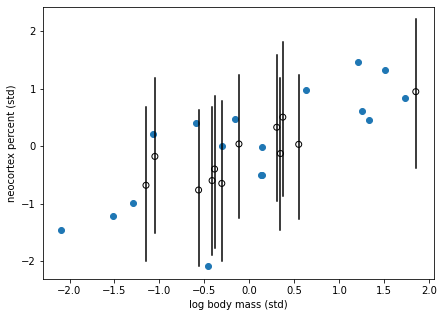

In [ ]:
obs_idx = ~d["neocortex.prop"].isna()
post = idata_m15_7.posterior

# Calculate the posterior mean and hdi for imputed values of B
B_impute_mu = post["MB_missing"].mean(dim=["chain", "draw"])
B_impute_ci = az.hdi(post, var_names=["MB_missing"])["MB_missing"]

# B vs K
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(B, K)
ax.scatter(B_impute_mu, K[~obs_idx], edgecolor="k", facecolor="none")
ax.plot(
    [B_impute_ci.sel(hdi="lower"), B_impute_ci.sel(hdi="higher")],
    [K[~obs_idx], K[~obs_idx]],
    color="k",
)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kcal milk (std)")

# M vs B
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(M, B)
ax.scatter(M[~obs_idx], B_impute_mu, edgecolor="k", facecolor="none")
ax.plot(
    [M[~obs_idx], M[~obs_idx]],
    [B_impute_ci.sel(hdi="lower"), B_impute_ci.sel(hdi="higher")],
    color="k",
)
ax.set_xlabel("log body mass (std)")
ax.set_ylabel("neocortex percent (std)");

In [ ]:
`np.stack([B_, M_])

array([[-2.08019603,         nan,         nan,         nan,         nan,
        -0.50864129, -0.50864129,  0.01074247,         nan,  0.21346968,
        -1.46196181, -0.98613926, -1.21567338,         nan,         nan,
         0.40111801,         nan,  0.47483699,         nan,  0.97579101,
                nan, -0.00768727,         nan,  0.61724867,  0.84175649,
                nan,  0.44635466,  1.46166614,  1.32595619],
       [-0.45583571, -0.41500236, -0.30715809, -0.56502542, -0.38747721,
         0.1274408 ,  0.14075054, -0.30715809, -1.05084431, -1.07626974,
        -2.0978301 , -1.29379736, -1.52018933, -1.14998219, -0.11641991,
        -0.59103922,  0.30355817, -0.15680955,  0.37107285,  0.6288397 ,
         0.34452284,  0.14075054,  0.54786869,  1.25273549,  1.7273591 ,
         1.84940334,  1.33415005,  1.21202044,  1.51036602]])

In [ ]:
K_ = standardize(d['kcal.per.g'])
B_ = standardize(d['neocortex.prop'])
M_ = standardize(d['logmass'])

_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(B_[index], K_[index])
ax[0].errorbar(B_impute_mu, K_[~index],xerr=B_impute_sd, 
               fmt='o',
               color='k', 
               markerfacecolor='none',
               markeredgewidth = 0.5,
               elinewidth = 1)
ax[0].set_xlabel("neocortex percent (std)")
ax[0].set_ylabel("kcal milk (std)")
plt.show()

# Code 15.24

In [ ]:
moralizing_gods = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Moralizing_gods.csv"

d = pd.read_csv(moralizing_gods, delimiter=";")
d.head()

,polity,year,population,moralizing_gods,writing
0,Big Island Hawaii,1000,3.729643,NaN,0
1,Big Island Hawaii,1100,3.729643,NaN,0
2,Big Island Hawaii,1200,3.598340,NaN,0
3,Big Island Hawaii,1300,4.026240,NaN,0
4,Big Island Hawaii,1400,4.311767,NaN,0


# Code 15.25

In [ ]:
print(d.shape)
d.moralizing_gods.value_counts(dropna=False)

(864, 5)


NaN    528
1.0    319
0.0     17
Name: moralizing_gods, dtype: int64

# Code 15.26

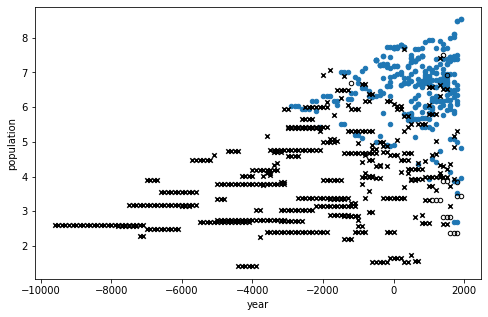

In [ ]:
_, ax = plt.subplots(figsize=(8, 5))
d[d.moralizing_gods == 1].plot.scatter('year','population', ax=ax)
d[d.moralizing_gods == 0].plot.scatter('year','population', color='none', edgecolors='k',ax=ax)
d[d.moralizing_gods.isna()].plot.scatter('year','population', c = 'k', marker = 'x',ax=ax)

# Code 15.27

In [ ]:
pd.pivot_table(data=d[['moralizing_gods']],
               index=d.moralizing_gods,columns=d.writing, 
               aggfunc=np.count_nonzero,
               dropna=False,)

moralizing_gods       
writing                       0      1
moralizing_gods                       
0.0                         0.0    0.0
1.0                         9.0  310.0

# Code 15.29

In [ ]:
N_houses = 100  # Number of houses to simulate
alpha = 5  # Average number of notes when cat is absent
beta = -3  # Difference in number of notes when cat is present
k_true = 0.5  # Probability of cat present
r = 0.2  # Probability of not knowing whether cat present/absent

cat_true = np.random.binomial(n=1, p=k_true, size=N_houses)
notes = np.random.poisson(lam=alpha + beta * cat_true, size=N_houses)
R_C = np.random.binomial(n=1, p=r, size=N_houses)
cat = cat_true.copy()
cat[R_C == 1] = -9

# Code 15.30

In [ ]:
with pm.Model() as m15_8:
  #priors
  a = pm.Normal("a", 0, 1)
  b = pm.Normal("b", 0, 0.5)
  k = pm.Beta("k", 2, 2)
  # cat NA
  custom_logp = pm.math.logsumexp(
      [pm.math.log(k)
      + pm.Poisson.dist(pm.math.exp(a + b)).logp(notes[cat == -9])
      , pm.math.log(1 - k)
      + pm.Poisson.dist(pm.math.exp(a)).logp(notes[cat == -9])]
  )
  # Using pm.Potential to add custom term to model logp
  notes_RC_1 = pm.Potential("notes|RC==1", custom_logp)

  # cat known present/absent
  cat_RC_0 = pm.Bernoulli("cat|RC==0", k, observed=cat[cat != -9])

  lam = pm.math.exp(a + b * cat[cat!=-9]) 
  notes_RC_0 = pm.Poisson("notes|RC==0", lam, observed=notes[cat != -9])

  idata_m15_8 = pm.sample(return_inferencedata=True)

az.summary(idata_m15_8,  round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [k, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.44,0.08,1.30,1.60,0.0,0.0,1404.89,1523.59,1.0
b,-0.77,0.13,-1.02,-0.53,0.0,0.0,1223.82,1475.15,1.0
k,0.52,0.05,0.42,0.62,0.0,0.0,1821.27,1333.53,1.0
